In [1]:
%matplotlib inline
import numpy as np
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('paper')
import pandas as pd

import pymc3 as pm

t, red_x, red_y, blue_x, blue_y  = np.genfromtxt("location_data_hw9_2018.csv", delimiter=',', skip_header = 1,unpack=True)

/home/deep/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#we start doing some pymc...
#we assume a normal prior as we expect the statistical variance to be
#normally distributed and we want our posteriors to be normal as well. we assume a fit of the form 
with pm.Model() as model:
    # Priors for unknown model parameters
    alpha_red = pm.Normal('alpha_red', mu=0, sd=1, shape = 2)
    beta_red = pm.Normal('beta_red', mu=0, sd=1, shape = 2)
    
    alpha_blue = pm.Normal('alpha_blue', mu=0, sd=1, shape = 2)
    beta_blue = pm.Normal('beta_blue', mu=0, sd=1, shape = 2)
    
    sigma = pm.HalfNormal('sigma', sd=1) #same error for both

    # Expected value of outcome
    mu_red_x = alpha_red[0] + beta_red[0]*t
    mu_red_y = alpha_red[1] + beta_red[1]*t
    
    mu_blue_x = alpha_blue[0] + beta_blue[0]*t
    mu_blue_y = alpha_blue[1] + beta_blue[1]*t

    # Likelihood (sampling distribution) of observations
    Y_red_x = pm.Normal('Y_red_x', mu=mu_red_x, sd=sigma, observed=red_x)
    Y_red_y = pm.Normal('Y_red_y', mu=mu_red_y, sd=sigma, observed=red_y)
    Y_blue_x = pm.Normal('Y_blue_x', mu=mu_blue_x, sd=sigma, observed=blue_x)
    Y_blue_y = pm.Normal('Y_blue_y', mu=mu_blue_y, sd=sigma, observed=blue_y)
    

In [3]:
#and we sample
with model:
    step = pm.NUTS()
    trace = pm.sample(50000, step=step, njobs=5, tune=1000)
    
burned_in = trace[5000:]
thinned = burned_in[::10]

Multiprocess sampling (5 chains in 5 jobs)
NUTS: [sigma_log__, beta_blue, alpha_blue, beta_red, alpha_red]
100%|██████████| 51000/51000 [02:23<00:00, 354.40it/s]


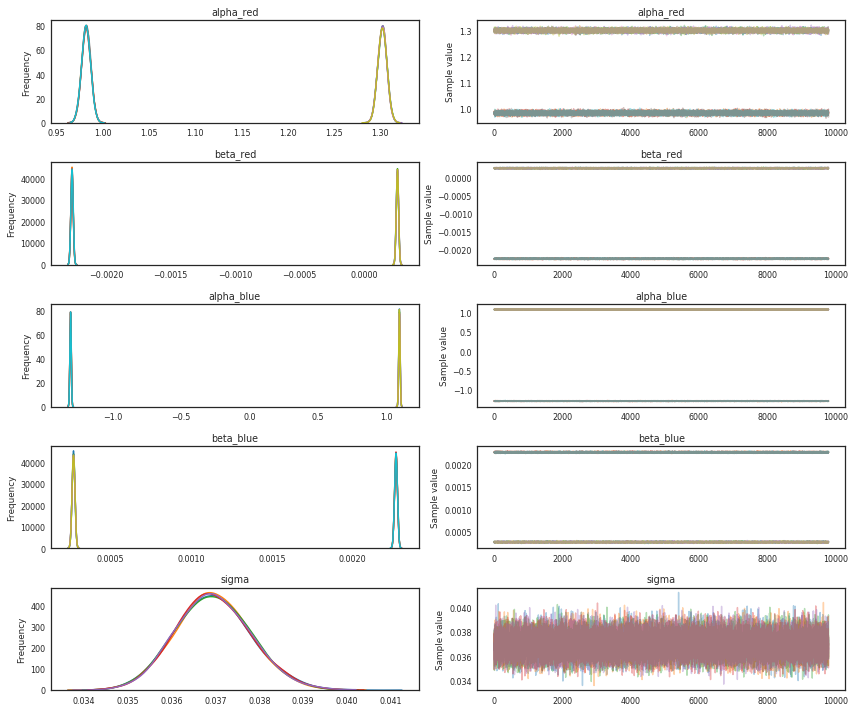

In [4]:
pm.traceplot(trace[1000:][::5]);

Note in the graphs above that the golden line corresponds to the x position estimation and the blue line to the y position estimation. What we have done is basically do a linear fit of our data. So in order to get the best fit line, you take $Color$ (x,y) = alpha\_$Color$(x,y) + beta\_$Color$ (x,y)* t. Notice that the x,y velocities are then given by the beta values.


In [5]:
pm.stats.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha_red__0,1.302278,0.004873,8.798656e-06,1.292743,1.311817,273574.999301,0.999991
alpha_red__1,0.981901,0.004885,9.673705e-06,0.972129,0.991309,270089.153460,0.999997
beta_red__0,0.000258,0.000009,1.600396e-08,0.000242,0.000276,274785.484088,0.999992
beta_red__1,-0.002263,0.000009,1.693761e-08,-0.002280,-0.002246,273835.267659,0.999998
alpha_blue__0,1.093516,0.004866,9.062898e-06,1.083899,1.102954,259869.281085,1.000012
alpha_blue__1,-1.304300,0.004892,8.590064e-06,-1.313852,-1.294722,265674.366936,1.000005
beta_blue__0,0.000271,0.000009,1.611265e-08,0.000254,0.000288,259949.109153,1.000009
beta_blue__1,0.002269,0.000009,1.601033e-08,0.002252,0.002287,266257.413914,0.999997
sigma,0.036948,0.000852,1.367142e-06,0.035305,0.038644,314698.744426,0.999992


So I was a little confused as to the relationship between a confidence interval and the HPD (highest posterior density), which is what our PyMC simulation actually gives us. To the best of my knowledge after some rather confused googling (statistics is really not my thing), the main difference is that the HPD is the $shortest$ possible interval containing the most probability, while the confidence interval is merely the shortest interval that gives a $symmetric$, dense probability distribution about the mean. So, because it doesn't seem to actually make a huge difference and it seems that statisticians use both, I am going respectfully take the approach that gives me less work to do and use the HPD intervals.

So now, we want the moment when both switch with 95% confidence which implies that we take the 97.5 hpd of red and the 2.5 hpd of blue to obtain: 441.36s for red and 583.416 for blue meaning that the time to 95% certainty is about 583s. For 5% confidence we take the opposite: 566 for blue and 426 for red, which means that our 5% certainty comes purely from the blue object and is at about 566s. Note that we can only do it in this fashion because we assume that the two distributions are independent.

But if we want speed too then we need to take a slightly different approach. We define a new model based on distance. This portion relies on the fact that the velocities should be uniform in time. We take the expected initially position from above and subtract off the positions of the particles in order to obtain their distance covered.

In [8]:
dist_red = np.sqrt(np.square(red_x - 1.302278) + np.square(red_y - 0.981901))
dist_blue = np.sqrt(np.square(blue_x - 1.093516) + np.square(blue_y + 1.304300))
with pm.Model() as model1:
    # Priors for unknown model parameters
    alpha_red = pm.Normal('alpha_red_1', mu=0, sd=1)
    beta_red = pm.Normal('beta_red_1', mu=0, sd=1)
    
    alpha_blue = pm.Normal('alpha_blue_1', mu=0, sd=1)
    beta_blue = pm.Normal('beta_blue_1', mu=0, sd=1)
    
    sigma = pm.HalfNormal('sigma_1', sd=1) #same error for both

    # Expected value of outcome
    mu_red = alpha_red + beta_red*t
    mu_blue = alpha_blue + beta_blue*t

    # Likelihood (sampling distribution) of observations
    Y_red = pm.Normal('Y_red', mu=mu_red, sd=sigma, observed=dist_red)
    Y_blue = pm.Normal('Y_blue', mu=mu_blue, sd=sigma, observed=dist_blue)
    
with model1:
    step = pm.NUTS()
    trace1 = pm.sample(50000, step=step, tune=1000)
    
burned_in1 = trace1[5000:]
thinned1 = burned_in1[::10]

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_1_log__, beta_blue_1, alpha_blue_1, beta_red_1, alpha_red_1]
100%|██████████| 51000/51000 [01:19<00:00, 642.25it/s]


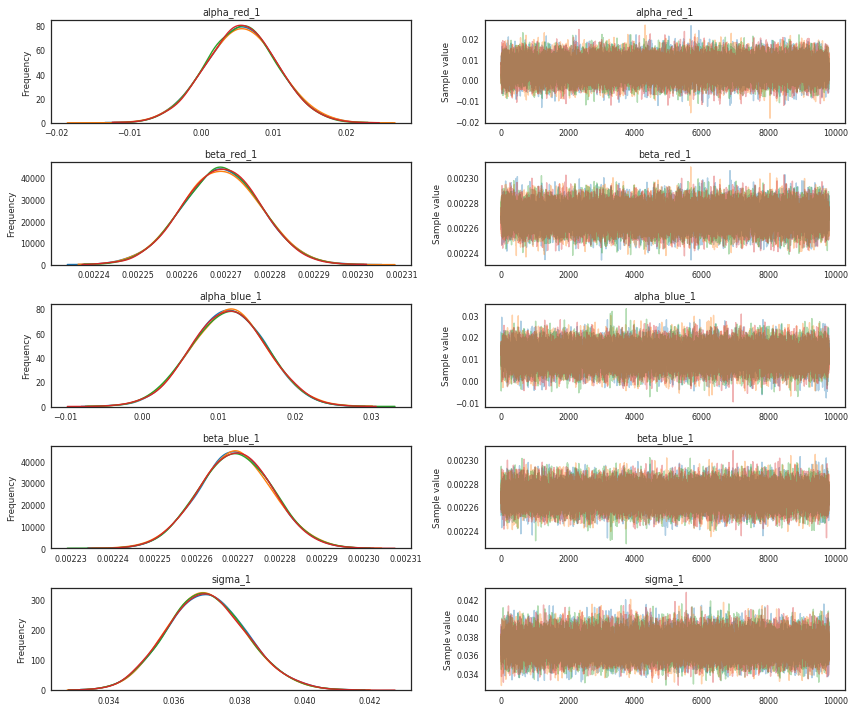

In [9]:
pm.traceplot(trace1[1000:][::5]);

Here again, we care about beta. Notice that the distributions are almost exactly the same. 

Now, we assume that the velocities are exactly the same. For so much statistics, having one less degree of freedom is unlikely to affect anything. Specifically for the  speed part, we can trivially just redefine both particles to support the same hypothesis as done below:

In [27]:
tot_dist = np.concatenate((dist_red, dist_blue))
tot_time = np.concatenate((t,t))
with pm.Model() as model:
    # Priors for unknown model parameters
    alpha_tot = pm.Normal('alpha_tot', mu=0.01, sd=.2)
    beta_tot = pm.Normal('beta_tot', mu=0.001, sd=.2)
    
    sigma_tot = pm.HalfNormal('sigma_tot', sd=.1)

    # Expected value of outcome
    mu_tot = alpha_tot + beta_tot*tot_time

    # Likelihood (sampling distribution) of observations
    Y_tot = pm.Normal('Y_tot', mu=mu_tot, sd=sigma_tot, observed=tot_dist)

with model:
    step = pm.NUTS()
    trace2  = pm.sample(30000, step=step, tune = 500)
    
burned_in2 = trace2[5000:]
thinned2 = burned_in2[::10]

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_tot_log__, beta_tot, alpha_tot]
100%|██████████| 30500/30500 [00:35<00:00, 850.55it/s]
The acceptance probability does not match the target. It is 0.9061170696737334, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9099146309136714, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9149988437138407, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9093168815371602, but should be close to 0.8. Try to increase the number of tuning steps.


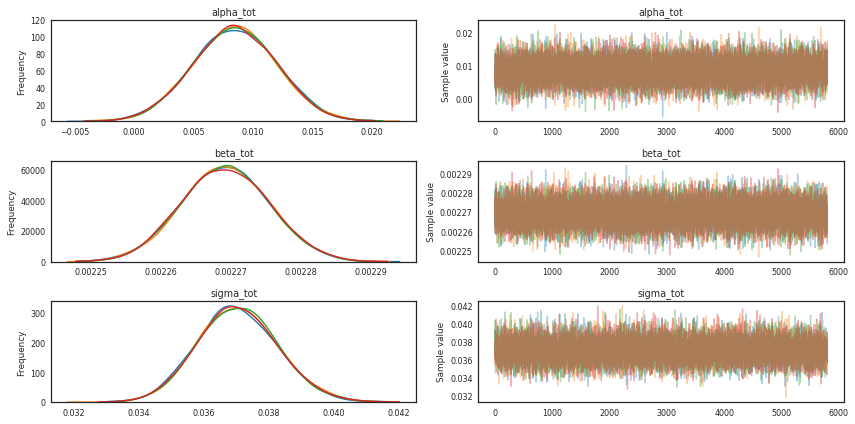

In [29]:
pm.traceplot(trace2[1000:][::5]);

Now, we have an estimate for the total velocity which we can use to eliminate one set of fits (i.e. we only need to perform the above analysis for v_x or v_y). However, it is important to note again that it is practically pointless for so many statistics so we will hold off to do this when we look at only the first 100 points as we do below starting with speed this time.

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_1_log__, beta_blue_1, alpha_blue_1, beta_red_1, alpha_red_1]
100%|██████████| 51000/51000 [01:03<00:00, 807.99it/s]


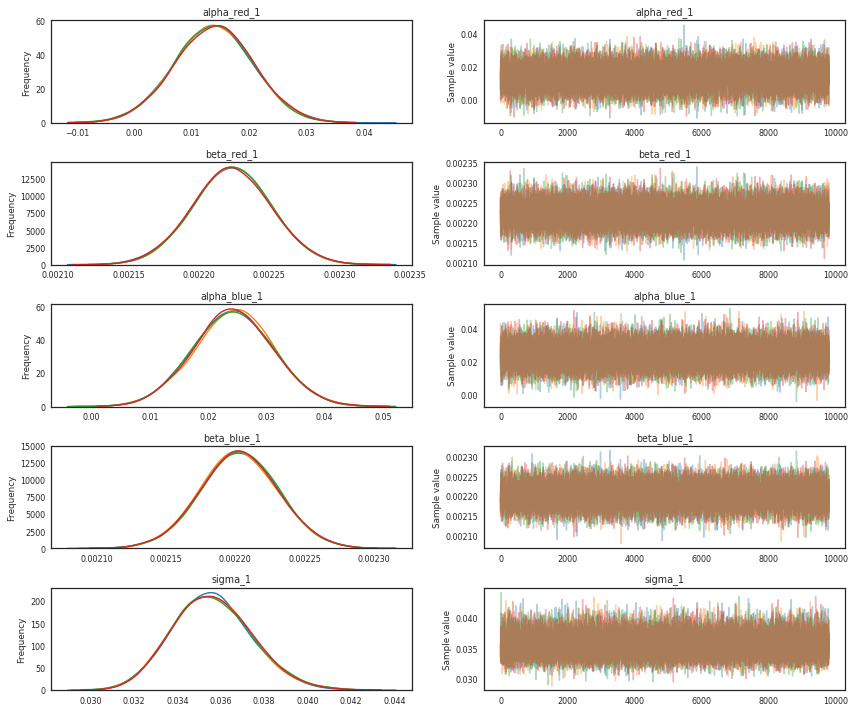

In [31]:
t, red_x, red_y, blue_x, blue_y  = t[0:100], red_x[0:100], red_y[0:100], blue_x[0:100], blue_y[0:100]

dist_red = np.sqrt(np.square(red_x - 1.302278) + np.square(red_y - 0.981901))
dist_blue = np.sqrt(np.square(blue_x - 1.093516) + np.square(blue_y + 1.304300))
with pm.Model() as model1:
    # Priors for unknown model parameters
    alpha_red = pm.Normal('alpha_red_1', mu=0, sd=1)
    beta_red = pm.Normal('beta_red_1', mu=0, sd=1)
    
    alpha_blue = pm.Normal('alpha_blue_1', mu=0, sd=1)
    beta_blue = pm.Normal('beta_blue_1', mu=0, sd=1)
    
    sigma = pm.HalfNormal('sigma_1', sd=1) #same error for both

    # Expected value of outcome
    mu_red = alpha_red + beta_red*t
    mu_blue = alpha_blue + beta_blue*t

    # Likelihood (sampling distribution) of observations
    Y_red = pm.Normal('Y_red', mu=mu_red, sd=sigma, observed=dist_red)
    Y_blue = pm.Normal('Y_blue', mu=mu_blue, sd=sigma, observed=dist_blue)
    
with model1:
    step = pm.NUTS()
    trace1 = pm.sample(50000, step=step, tune=1000)
    
burned_in1 = trace1[5000:]
thinned1 = burned_in1[::10]
pm.traceplot(trace1[1000:][::5]);

Now we do the same analysis for just individual velocities:

Multiprocess sampling (5 chains in 5 jobs)
NUTS: [sigma_log__, beta_blue, alpha_blue, beta_red, alpha_red]
100%|██████████| 51000/51000 [02:32<00:00, 333.89it/s]


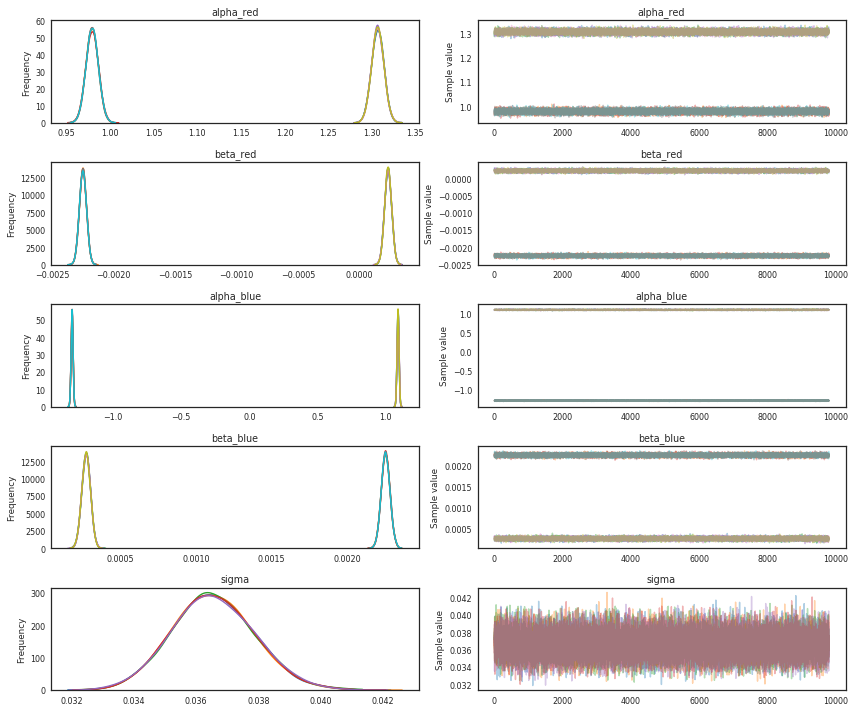

In [32]:
with pm.Model() as model:
    # Priors for unknown model parameters
    alpha_red = pm.Normal('alpha_red', mu=0, sd=1, shape = 2)
    beta_red = pm.Normal('beta_red', mu=0, sd=1, shape = 2)
    
    alpha_blue = pm.Normal('alpha_blue', mu=0, sd=1, shape = 2)
    beta_blue = pm.Normal('beta_blue', mu=0, sd=1, shape = 2)
    
    sigma = pm.HalfNormal('sigma', sd=1) #same error for both

    # Expected value of outcome
    mu_red_x = alpha_red[0] + beta_red[0]*t
    mu_red_y = alpha_red[1] + beta_red[1]*t
    
    mu_blue_x = alpha_blue[0] + beta_blue[0]*t
    mu_blue_y = alpha_blue[1] + beta_blue[1]*t

    # Likelihood (sampling distribution) of observations
    Y_red_x = pm.Normal('Y_red_x', mu=mu_red_x, sd=sigma, observed=red_x)
    Y_red_y = pm.Normal('Y_red_y', mu=mu_red_y, sd=sigma, observed=red_y)
    Y_blue_x = pm.Normal('Y_blue_x', mu=mu_blue_x, sd=sigma, observed=blue_x)
    Y_blue_y = pm.Normal('Y_blue_y', mu=mu_blue_y, sd=sigma, observed=blue_y)
    
with model:
    step = pm.NUTS()
    trace = pm.sample(50000, step=step, njobs=5, tune=1000)
    
burned_in = trace[5000:]
thinned = burned_in[::10]
pm.traceplot(trace[1000:][::5]);

In [34]:
pm.stats.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha_red__0,1.306827,0.006951,1.395011e-05,1.293152,1.320461,266039.755846,0.999996
alpha_red__1,0.979470,0.006955,1.415365e-05,0.965883,0.993134,265120.852420,1.000005
beta_red__0,0.000233,0.000028,5.431192e-08,0.000177,0.000287,270199.415474,0.999996
beta_red__1,-0.002248,0.000028,5.501950e-08,-0.002304,-0.002193,264209.608734,1.000004
alpha_blue__0,1.091688,0.006963,1.208240e-05,1.078247,1.105525,269007.499477,0.999994
alpha_blue__1,-1.300500,0.006957,1.367353e-05,-1.314261,-1.286968,269231.758707,1.000008
beta_blue__0,0.000277,0.000028,5.034192e-08,0.000222,0.000333,268157.321663,0.999994
beta_blue__1,0.002250,0.000028,5.208388e-08,0.002195,0.002305,271010.280886,1.000005
sigma,0.036566,0.001316,2.446873e-06,0.034038,0.039190,309736.877061,0.999992


Again we can do the same analysis as above and we find 95%: ~599s from blue. And 5%: ~558s. Now we move on to assume that the velocities are the same. This allows us to pick whichever fit from above is better. We look at the standard devations of the velocities for each color and find that for red, our y-estimates were slightly better which allows us to calculate x from y via: V_y = sqrt(V_x^2 + V^2). This should give it the same error as the V_x which is slightly better. For blue we see the same thing.

Also, for the combined velocities, we find that the posteriors are much narrower (displayed below) and thus the answer for part a is improved significantly when the statistics are poor and the total speed is assumed to be the same.

In [38]:
tot_dist = np.concatenate((dist_red, dist_blue))
tot_time = np.concatenate((t,t))
with pm.Model() as model:
    # Priors for unknown model parameters
    alpha_tot = pm.Normal('alpha_tot', mu=0.01, sd=.2)
    beta_tot = pm.Normal('beta_tot', mu=0.001, sd=.2)
    
    sigma_tot = pm.HalfNormal('sigma_tot', sd=.1)

    # Expected value of outcome
    mu_tot = alpha_tot + beta_tot*tot_time

    # Likelihood (sampling distribution) of observations
    Y_tot = pm.Normal('Y_tot', mu=mu_tot, sd=sigma_tot, observed=tot_dist)

with model:
    step = pm.NUTS()
    trace2  = pm.sample(30000, step=step, tune = 500)
    
burned_in2 = trace2[5000:]
thinned2 = burned_in2[::10]

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_tot_log__, beta_tot, alpha_tot]
100%|██████████| 30500/30500 [00:34<00:00, 881.27it/s]
The acceptance probability does not match the target. It is 0.8900144082124489, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8850353811397119, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8951042679251091, but should be close to 0.8. Try to increase the number of tuning steps.


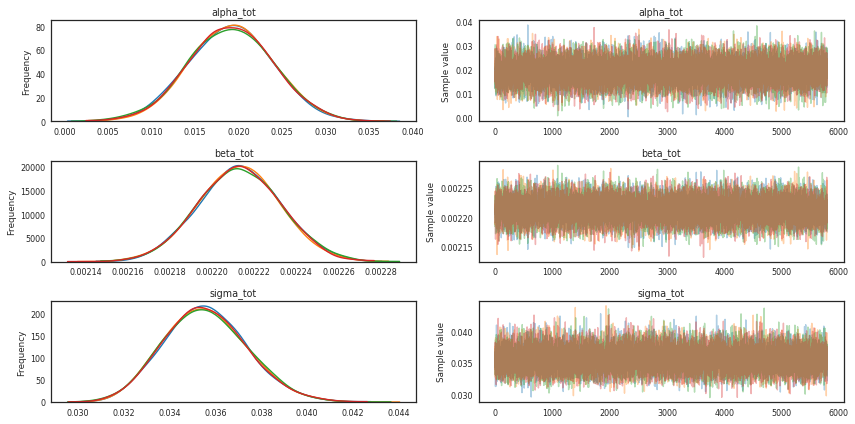

In [39]:
pm.traceplot(trace2[1000:][::5]);